# Feature Construction, Regularization

<img src="https://miro.medium.com/max/761/1*nrWncnoJ4V_BkzEf1pd4MA.png" width=500>


In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
pd.set_option('display.max_columns', 500)
%matplotlib inline

## Part 1: Construct features, Ridge

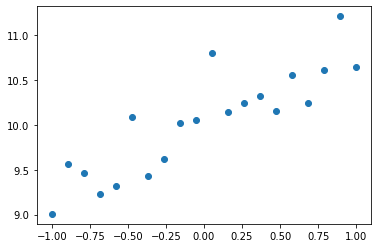

In [2]:
# First, read the csv into a df

df = pd.read_csv("L6.csv")
#display(df)

plt.scatter(df.x,df.y)

In [3]:
# Build linear regression model with Pipeline, fit and predict
M1 = Pipeline([
    ('poly1', PolynomialFeatures(degree=6, include_bias=False)),
    ('lin1', LinearRegression(fit_intercept=True))
])

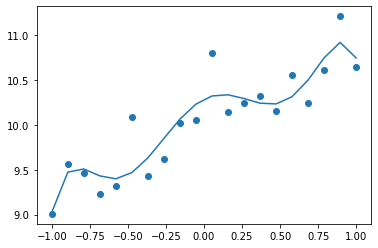

In [4]:
# Define the x values and x_new values here
x = df.x.values.reshape(-1,1)
x_new = np.linspace(-1,1,len(x)).reshape(-1,1)

# Plot the points, also plot prediction
plt.scatter(x, df.y)
ypred = M1.fit(x,df.y).predict(x_new)
plt.plot(x_new, ypred)

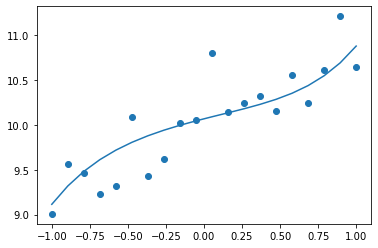

In [5]:
# This seems wiggly. What if we use Ridge regression? 
# Side note: In practice, we don't shrink the bias term
# <https://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression>
M2 = Pipeline([
    ('poly2', PolynomialFeatures(degree=6,include_bias=False)),
    ('scal2', StandardScaler()),
    ('ridge2', Ridge(alpha=5.0, fit_intercept=True))
])

plt.scatter(x, df.y)
ypred = M2.fit(x,df.y).predict(x_new)
plt.plot(x_new, ypred)

In [6]:
# Aside: what features did we construct (PolynomialFeatures)?
Xc = M1.named_steps['poly1'].fit_transform(df.x.values.reshape(-1,1))
display(pd.DataFrame(Xc).head())

# We standardized our features for effective regularization
#print((Xc[1,2]-np.mean(Xc[:,2]))/np.std(Xc[:,2])) #check formula
Xc = StandardScaler().fit_transform(Xc)
display(pd.DataFrame(Xc).head())

,0,1,2,3,4,5
0,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000
1,-0.894737,0.800554,-0.716285,0.640887,-0.573425,0.513064
2,-0.789474,0.623269,-0.492054,0.388464,-0.306682,0.242117
3,-0.684211,0.468144,-0.320309,0.219159,-0.149951,0.102598
4,-0.578947,0.335180,-0.194052,0.112346,-0.065042,0.037656


,0,1,2,3,4,5
0,-1.647509,1.923876,-2.288395,2.354589,-2.625946,2.598636
1,-1.474087,1.316336,-1.639144,1.236850,-1.505783,1.034603
2,-1.300665,0.776301,-1.126015,0.451184,-0.805330,0.164323
3,-1.127243,0.303770,-0.732994,-0.075777,-0.393763,-0.283812
4,-0.953821,-0.101257,-0.444067,-0.408233,-0.170797,-0.492405


In [7]:
# How do the coefficients look?

print(f"M1 coefficients: {M1.named_steps['lin1'].coef_} | intercept: {M1.named_steps['lin1'].intercept_}")
print(f"M2 coefficients: {M2.named_steps['ridge2'].coef_} | intercept: {M2.named_steps['ridge2'].intercept_}")

M1 coefficients: [ 0.86649497 -3.7238559  -0.33985167  9.27759149  0.33285497 -5.95498747] | intercept: 10.286410833194555
M2 coefficients: [ 0.26264477 -0.03604224  0.12595432  0.01336734  0.06098453 -0.0009332 ] | intercept: 10.03645005795


## Part 2: Finding a better $\lambda$ (Hyperparam tuning)

lam: 0.01831563888873418 | MSE: 0.8095927451701815
lam: 0.0198571344320536 | MSE: 0.7103012820909573
lam: 0.021528366564116053 | MSE: 0.6230984069747512
lam: 0.023340254280134736 | MSE: 0.5468734519574396
lam: 0.02530463554858724 | MSE: 0.48062784476867976
lam: 0.02743434465458312 | MSE: 0.42345612464203175
lam: 0.029743296052666266 | MSE: 0.3745291490355087
lam: 0.03224657527690433 | MSE: 0.33307982649304996
lam: 0.03496053750222628 | MSE: 0.2983915269759314
lam: 0.03790291440095852 | MSE: 0.2697891579977192
lam: 0.04109292999270688 | MSE: 0.24663275852708905
lam: 0.04455142624448969 | MSE: 0.2283133564068077
lam: 0.04830099924173013 | MSE: 0.2142507603305089
lam: 0.05236614681978153 | MSE: 0.20389291348818422
lam: 0.05677342862053571 | MSE: 0.19671642029073577
lam: 0.06155163961984455 | MSE: 0.1922278661762185
lam: 0.0667319982594962 | MSE: 0.1899655785480307
lam: 0.07234835041290566 | MSE: 0.18950151915858973
lam: 0.07843739051713067 | MSE: 0.19044304957471242
lam: 0.085038901315977

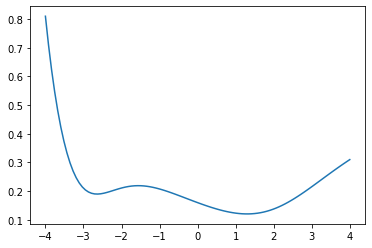

In [8]:
# Ok, let's compare models with various hyperparameters using 5-fold CV
# We'll consider some range of lambda values and get our cv scores
# ("lambda" [regularization coefficient] is called "alpha" in sklearn.Ridge)

lam = np.exp(np.linspace(-4,4,100))
mses = np.zeros(len(lam))
for i in range(len(lam)):
    M3 = Pipeline([
        ('poly3', PolynomialFeatures(degree=6,include_bias=False)),
        ('scal3', StandardScaler()),
        ('ridge3', Ridge(alpha=lam[i], fit_intercept=True))
    ])
    #M3.set_params(**{'ridge3':Ridge(alpha=lam[i],fit_intercept=True)})
    cvsc = cross_val_score(M3, x, df.y,cv=5,scoring = 'neg_mean_squared_error')
    mses[i] = -cvsc.mean()
    print(f"lam: {lam[i]} | MSE: {mses[i]}")

plt.plot(np.log(lam),mses)

In [9]:
# So low let's look at the crossvalidation error for the best setting of lambda 
M3 = Pipeline([
        ('poly3', PolynomialFeatures(degree=6,include_bias=False)),
        ('scal3', StandardScaler()),
        ('ridge3', Ridge(alpha=np.exp(1.5), fit_intercept=True))
    ])

print(-cross_val_score(M2, x, df.y,cv=5,scoring = 'neg_mean_squared_error').mean())

0.12343727045629886


## Part 3: Lasso Regularization

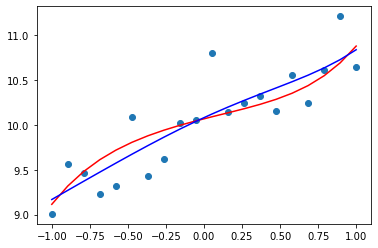

In [14]:
# Finally, let's consider the same dataset and perform Lasso Regularization
M4 = Pipeline([
    ('poly4',PolynomialFeatures(degree=6,include_bias=False)),
    ('scal4', StandardScaler()),
    ('lasso4', Lasso(alpha=0.005, fit_intercept=True))
])

ypred4 = M4.fit(x,df.y).predict(x_new)
plt.scatter(x,df.y)
plt.plot(x,ypred,'r-',x,ypred4,'b-')

In [15]:
# Let's check the coefficients. What do you notice compared to the ridge? 
(M2.named_steps['ridge2'].coef_, M4.named_steps['lasso4'].coef_)

(array([ 0.26264477, -0.03604224,  0.12595432,  0.01336734,  0.06098453,
        -0.0009332 ]),
 array([ 0.47117248, -0.06577208,  0.        ,  0.0393283 ,  0.02196659,
         0.        ]))